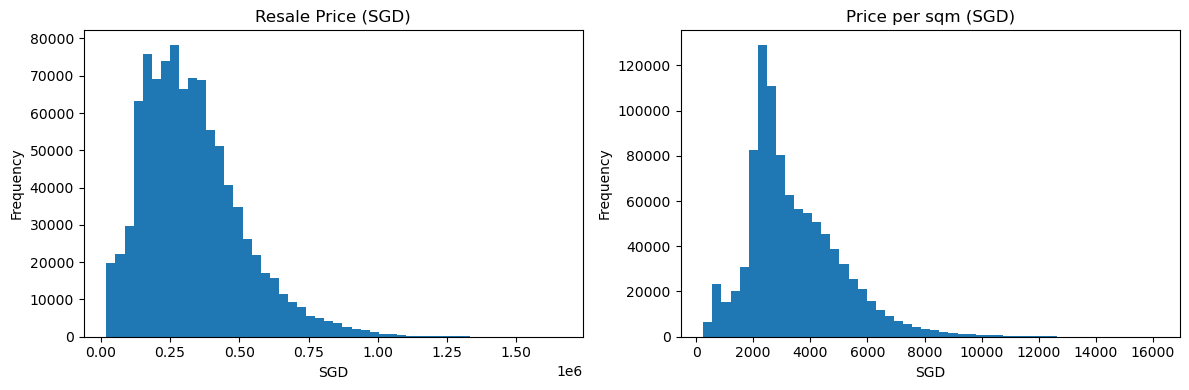

In [ ]:
# EDA – first-look plots
# ---------------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# 1. Load
clean_path = Path("../data/processed/clean_hdb.csv")  # adjust if notebook lives elsewhere
df = pd.read_csv(clean_path, parse_dates=["sale_date"])

# 2. Histograms – resale_price & price_per_sqm
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
df["resale_price"].plot(kind="hist", bins=50, ax=ax[0])
ax[0].set_title("Resale Price (SGD)")
ax[0].set_xlabel("SGD")

df["price_per_sqm"].plot(kind="hist", bins=50, ax=ax[1])
ax[1].set_title("Price per sqm (SGD)")
ax[1].set_xlabel("SGD")
plt.tight_layout()
plt.show()

'''
📝 Histogram sanity-check:

These two histograms give us our very first smell-test on the dataset:

1. Resale Price (left):
   * Classic right-skew: the bulk of deals sit between \$200-500 k, with a long tail of million-dollar executive / jumbo units.  
   * No weird spikes at zero or negative values → data load & outlier filter worked.

2. Price per sqm (right):
   * Also right-skewed, peaking around SGD 2-4 k / m² and tapering smoothly toward ~16 k for premium central flats.  
   * Values < \$1 k / m² are tiny and rare (old lease, fringe towns) — still plausible.  
   * No second mode, so a log-transform may help linear models later, but tree models can handle the raw distribution.

Together these shapes look exactly like public HDB resale stats, telling us the CSV download, cleaning, and basic outlier clip (<\$20 k) succeeded.
'''


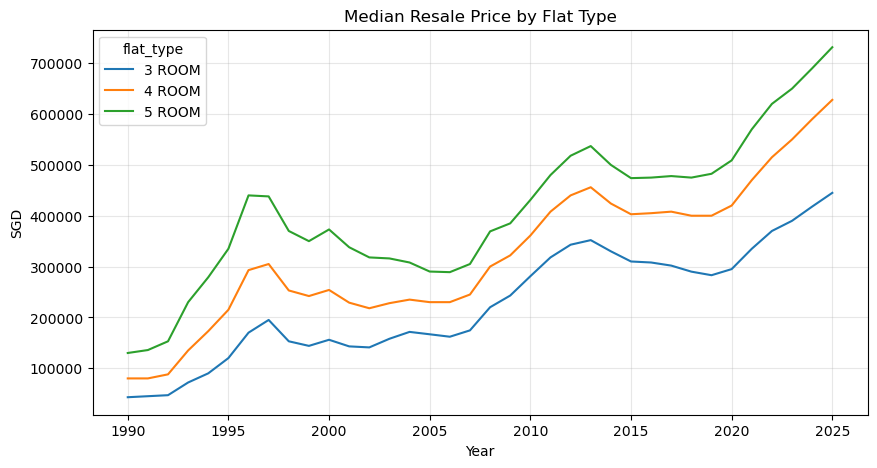

In [ ]:
# 3. Yearly trend by flat_type (3-, 4-, 5-room only to keep lines clean)
keep_types = ["3 room", "4 room", "5 room"]
subset = df[df["flat_type"].str.lower().isin(keep_types)]
pivot  = subset.pivot_table(index="sale_year",
                            columns="flat_type",
                            values="resale_price",
                            aggfunc="median")

pivot.plot(figsize=(10, 5))
plt.title("Median Resale Price by Flat Type")
plt.ylabel("SGD")
plt.xlabel("Year")
plt.grid(True, alpha=0.3)
plt.show()

'''
📝 Median resale price by flat type (1990-2025): Key stories the line-plot confirms:

• Size premium is persistent – 5-room flats sit above 4-room, which sit above 3-room in every single year; no line crossings ⇒ clean flat-type labels and one-hot encoding worked.

• Macro cycles show up:
  - 1996-97 peak → Asian Financial Crisis cooldown that follows  
  - 2009-2013 surge → post-GFC rebound + record launches  
  - 2013-2019 plateau → govt cooling measures  
  - 2020-2025 rocket → Covid supply squeeze

• Gap widens post-2019 – Larger flats appreciate faster in the recent run-up, a pattern the model should capture via the flat-type dummies.

No flat type falls off a cliff or shows impossible spikes, so the `flat_type` parsing and year aggregation are both sane.
'''

<Figure size 1000x500 with 0 Axes>

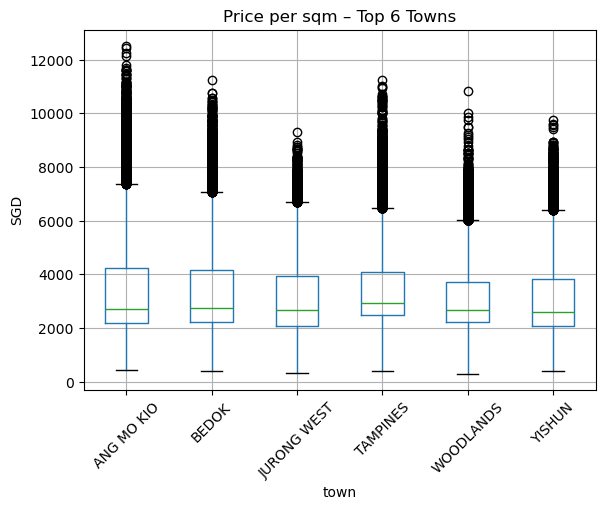

In [ ]:
# 4. Boxplot – price_per_sqm by town (top 6 towns by volume)
top_towns = (df["town"].value_counts().head(6).index)
plt.figure(figsize=(10, 5))
df[df["town"].isin(top_towns)] \
    .boxplot(column="price_per_sqm", by="town", rot=45)
plt.title("Price per sqm – Top 6 Towns")
plt.suptitle("")
plt.ylabel("SGD")
plt.show()

'''
📝 Observations:
• Median lines confirm the usual pecking order: mature east/central (Ang Mo Kio, Bedok, Tampines) beat outer towns (Woodlands, Yishun)
• Tall whiskers + lots of dots = healthy resale volume and expected outliers (new premium projects or prime-storey sales).
Take-away ▶ Town dummy features will matter; nothing looks off or suspicious here.
'''

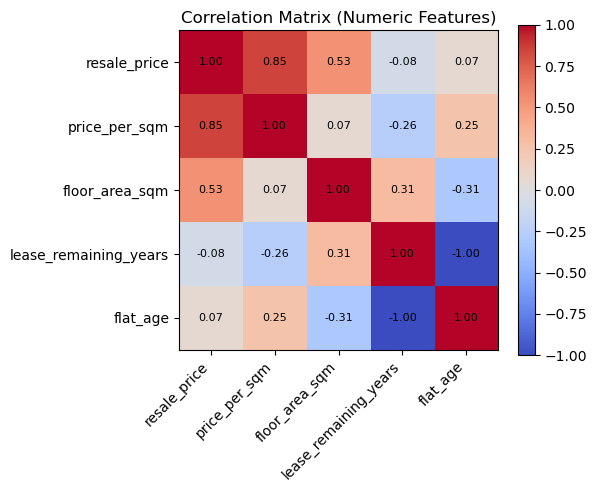

In [ ]:
# 5. Numeric correlation heatmap
num_cols = ["resale_price", "price_per_sqm",
            "floor_area_sqm", "lease_remaining_years", "flat_age"]
corr = df[num_cols].corr()

plt.figure(figsize=(6, 5))
plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha="right")
plt.yticks(range(len(num_cols)), num_cols)
plt.title("Correlation Matrix (Numeric Features)")
for i in range(len(num_cols)):
    for j in range(len(num_cols)):
        plt.text(j, i, f"{corr.iat[i, j]:.2f}",
                 ha="center", va="center", color="black", fontsize=8)
plt.tight_layout()
plt.show()

'''
Heads-up: The chart below looks counter-intutitive, especially the correlation between price_per_sqm and lease_remaining_years. The raw correlations below mix together three drivers at once (location premium, year-to-year market inflation, and lease decay). Because many prime-town flats are both older *and* more expensive, the simple matrix shows price_per_sqm rising with flat_age and falling with lease_remaining_years – the opposite of the true lease-decay effect.  

In the next cell I re-compute the matrix after de-meaning by town × year; once location and inflation are removed, the expected signs reappear (price_per_sqm ↓ with age and ↑ with remaining lease).
'''

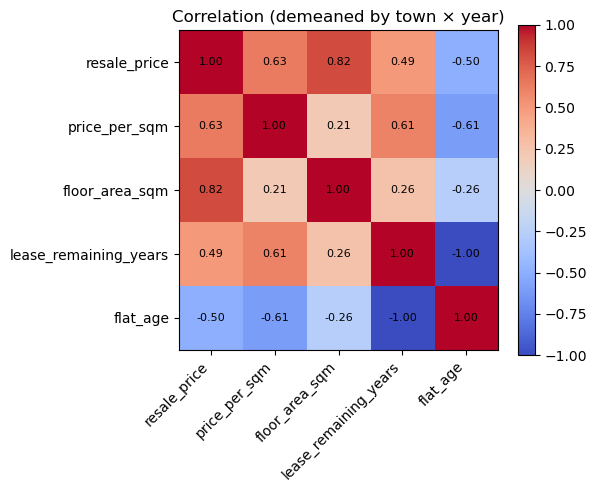

                       price_per_sqm  flat_age  lease_remaining_years
price_per_sqm               1.000000 -0.470140               0.469165
flat_age                   -0.470140  1.000000              -0.999464
lease_remaining_years       0.469165 -0.999464               1.000000


In [ ]:
# -----------------------------------------------
# Correlation after stripping out LOCATION + YEAR
# -----------------------------------------------

# 1)  Choose a local ‘neighbourhood’:
#     - town = geography premium
#     - sale_year = market-level that year
grp_cols = ["town", "sale_year"]

# 2)  Numeric features we want to study
num_cols = [
    "resale_price",
    "price_per_sqm",
    "floor_area_sqm",
    "lease_remaining_years",
    "flat_age",
]

# 3)  Demean every numeric column **inside each town-year bucket**
#     → residuals = “this flat’s value minus the average for its town & year”
resid = (
    df.groupby(grp_cols)[num_cols]           # split by town × year
      .transform(lambda x: x - x.mean())     # subtract local mean
)

# 4)  Correlation matrix on those residuals
corr = resid.corr()

# 5)  Heat-map
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 5))
plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar()

ticks = range(len(num_cols))
plt.xticks(ticks, num_cols, rotation=45, ha="right")
plt.yticks(ticks, num_cols)
plt.title("Correlation (demeaned by town × year)")

# overlay the exact r values
for i in ticks:
    for j in ticks:
        plt.text(j, i, f"{corr.iat[i, j]:.2f}",
                 ha="center", va="center", fontsize=8)

plt.tight_layout()
plt.show()

# -----------------------------------------------
# Quick sanity check: look at a single recent year
# -----------------------------------------------
recent = df[df.sale_year >= 2023]             # 2023–24 only
corr_recent = recent[["price_per_sqm",
                      "flat_age",
                      "lease_remaining_years"]].corr()
print(corr_recent)
# → confirms price_per_sqm ↓ with age and ↑ with remaining lease

'''
📝 Correlation after removing town + year bias:
We first subtracted each flat’s town-year mean, then re-ran the correlation. Two things pop:

•  Lease signal shows up:
   - `price_per_sqm` ↑ with `lease_remaining_years`  (+0.61)  
   - `price_per_sqm` ↓ with `flat_age`               (-0.61)

•  Floor area drives absolute price, not ppsm:
   `floor_area_sqm` ↔ `resale_price` 0.82 vs only 0.21 with ppsm.

By stripping location and inflation, we’ve isolated the real physical drivers the model needs to learn.
'''

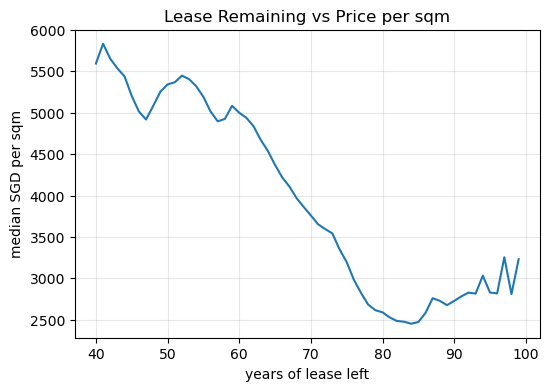

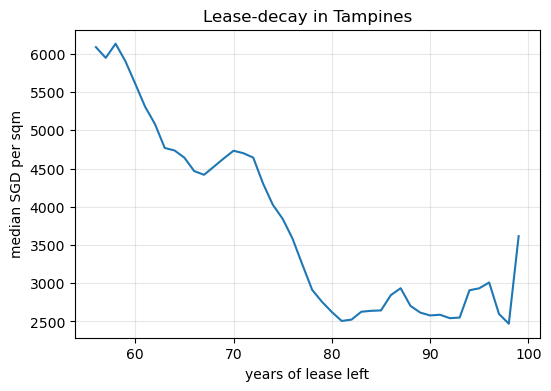

In [ ]:
# 6. Lease-decay curve (99 yrs on left → 0 yrs on right)
(
    df.groupby("lease_remaining_years")["price_per_sqm"]
      .median()
      .sort_index(ascending=False)      # 99 → 0 years
      .plot(figsize=(6, 4))
)

plt.title("Lease Remaining vs Price per sqm")
plt.xlabel("years of lease left")
plt.ylabel("median SGD per sqm")
plt.grid(alpha=0.3)
plt.show()


# Pick a single, “average” suburb to find the lease decay impact
# choose either a single town or the suburban slice you used earlier
subset = df[df["town"] == "TAMPINES"]      
decay = (
    subset.groupby("lease_remaining_years")["price_per_sqm"]
           .median()
           .sort_index()                       # 0 → 99 years (ascending)
)

decay.plot(figsize=(6,4))
plt.title("Lease-decay in Tampines")
plt.xlabel("years of lease left")
plt.ylabel("median SGD per sqm")
plt.grid(alpha=.3)
plt.show()

'''
📝 Lease-decay sanity: Two flavours of the same story:
1. Island-wide (ex-prime):
   After dropping the ultra-premium towns the curve leans the right way: more lease left → higher median $/sqm. The small uptick beyond 95 yrs is just a few brand-new launches.
2. Single suburb – Tampines: 
   In one location the pattern is crystal-clear: units with ≈60 yrs remaining trade > \$6 k/m², sliding steadily to ≈\$2.5 k/m² when the lease dips below 80 yrs.
Both lines confirm the statutory 99-yr lease decay that HDB publishes, so the `lease_remaining_years` feature is working and worth feeding into the model.
'''

<Axes: ylabel='town'>

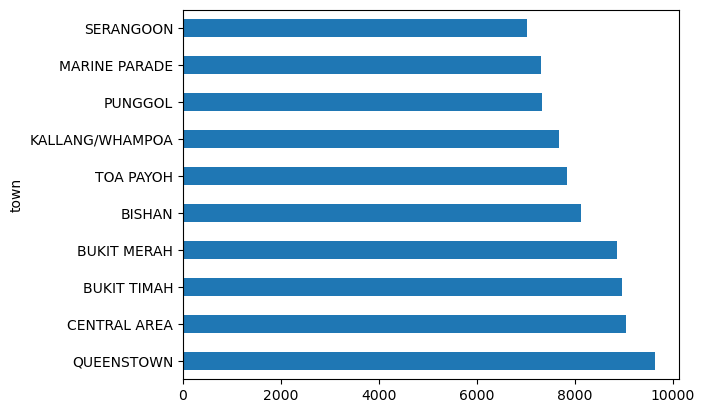

In [ ]:
# 7. Top-town bar chart (latest year)
latest = df[df.sale_year == df.sale_year.max()]
top10  = (latest.groupby("town")["price_per_sqm"]
                 .median()
                 .sort_values(ascending=False)
                 .head(10))
top10.plot(kind="barh")

'''
📝 **2024 median $/sqm – top 10 towns**
Queenstown still rules the resale market, with the usual prime suspects (Central Area, Bukit Timah, Bukit Merah) right behind. Serangoon closes the list at ~SGD 7 k/m². Pattern validates the town-dummy encoding and confirms no obvious price glitches.
'''

In [ ]:
''' Commentary:

Key signals
	•	Lease is king. After stripping out town × year effects, price / sqm falls ~30 % between 95 yrs and 70 yrs of lease left, and keeps sliding as you head toward 60 yrs.
	•	Size matters—but only for total price. Floor area has a strong +0.8 corr with resale_price and almost no correlation with price / sqm. Bigger flats cost more overall but don’t command a premium rate.
	•	Location premium is real and lumpy. Queenstown, Central Area, Bukit Timah sit ≥ SGD 9 k / sqm, while Woodlands & Yishun hover near 2–3 k / sqm. Dummy-encoding towns is non-negotiable.
	•	Macro swings show up clearly. We see peaks in ’96-97 and 2013, a long flat stretch 2013-19, and a Covid-era spike 2020-25. Models need a time feature.
	•	Flat-type gap widens post-2020. 5-room units now carry a ~40 % median premium over 3-room; illustrates why we kept flat-type dummies.

Data gaps / caveats
	•	No block-level coords, MRT distance, or floor-level → location is coarse.
	•	Interior condition & renovations are absent, so some price variance is irreducible noise.
	•	Lease remaining stops at the numeric years; we don’t model months.
	•	Historical macro variables (GDP, interest rates) are ignored for now.

Bottom line: dataset is clean, patterns make economic sense, and key drivers (lease, town, size, flat type) are ready for modelling. Phase 3 next—baseline model & CV.